In [1]:
#importing necessary libraries
from api.mapbox_api_walking import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod
from collections import defaultdict
from shapely.ops import unary_union

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
censusTracts.shape

(869, 63)

In [4]:
branchInfo.loc[branchInfo['BRANCH'] == 'Roosevelt']

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
60,Roosevelt,,1101 W. Taylor Street,Chicago,IL,60607,,,"(41.86943838326072, -87.6544586134924)",1,None


In [5]:
branchInfo = branchInfo.drop([60,60])
branchInfo = branchInfo.set_index('BRANCH')
branchInfo = branchInfo.reset_index()
branchInfo

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
0,Albany Park,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",3401 W. Foster Ave.,Chicago,IL,60625,(773) 539-5450,https://www.chipublib.org/locations/3/,"(41.97557881655979, -87.71361314512697)",0,None
1,Altgeld,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",955 E. 131st Street,Chicago,IL,60827,(312) 747-3270,https://www.chipublib.org/locations/4/,"(41.65719847558056, -87.59883829075173)",0,None
2,Archer Heights,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5055 S. Archer Ave.,Chicago,IL,60632,(312) 747-9241,https://www.chipublib.org/locations/5/,"(41.80110836194246, -87.72648385568911)",0,None
3,Austin,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5615 W. Race Ave.,Chicago,IL,60644,(312) 746-5038,https://www.chipublib.org/locations/6/,"(41.88917312206642, -87.7658203582574)",0,None
4,Austin-Irving,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",6100 W. Irving Park Rd.,Chicago,IL,60634,(312) 744-6222,https://www.chipublib.org/locations/7/,"(41.95312267684315, -87.77928489355646)",0,None
...,...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"Mon. & Wed., Noon-8; Tue. & Thu., 10-6; Fri. &...",830 W. 119th St.,Chicago,IL,60643,(312) 747-1425,https://www.chipublib.org/locations/78/,"(41.67790647382097, -87.6431683153105)",0,None
77,West Town,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",1625 W. Chicago Ave.,Chicago,IL,60622,(312) 743-0450,https://www.chipublib.org/locations/79/,"(41.89594730478282, -87.66829305460979)",0,None
78,"Whitney M. Young, Jr.","Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",415 East 79th St.,Chicago,IL,60619,(312) 747-0039,https://www.chipublib.org/locations/80/,"(41.7510184591363, -87.61495065361933)",0,None
79,Woodson Regional Library,"Mon. - Thurs., 9-8; Fri. & Sat., 9-5; Sun., 1-5",9525 S. Halsted St.,Chicago,IL,60628,(312) 747-6900,https://www.chipublib.org/locations/81/,"(41.720694885749005, -87.64304817213312)",0,None


In [6]:
branchCopy = branchInfo

In [7]:
branchCopy[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchCopy['LOCATION']]
branchCopy = branchCopy.drop(columns='LOCATION')


In [8]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [9]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [10]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [11]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary, key, iso_dict):
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            iso_dict[df.loc[i, key]] = overlapPolygon
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            dictionary[df.loc[i, key]] = propOverlap
            
            
            if len(df.loc[i, 'to merge list']) > 0:
                hold = (df.loc[i, 'to merge list'][0]).copy()
                c = len(hold.items())
                hold[c] = overlapPolygon
                df.loc[i, 'to merge list']= [hold]
 
            else:
                first = {0:overlapPolygon}
                df.loc[i, 'to merge list'] = [first]
            
    return dictionary


In [12]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [13]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf, idf, scoreString, dictString, cgs, igs, lat, lon, key, travelTime):
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    cdf['to merge list'] = np.empty((len(cdf), 0)).tolist()
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas

    
   
    for i in range(len(idf)):
        # Create a new dictionary for tracking isochrones
        iso_dict = defaultdict(list)
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs], cdf, cgs, dictionary, key, iso_dict)
        idf.loc[i,dictString] = [dictionary]
        idf.loc[i,'iso geometries'] = [iso_dict]
        
        for j in range(len(cdf)):
           
            if dictionary.get(cdf.loc[j, key]) != None:
                score = cdf.loc[j, scoreString]
                cdf.loc[j, scoreString] = score + dictionary.get(cdf.loc[j, key])
            
    for i in range(len(cdf)):
        if len(cdf.loc[i, 'to merge list']) > 0:
            toMerge = (cdf.loc[i, 'to merge list'][0]).copy()
            for tract_key, polygons in toMerge.items():
                merged_geom = unary_union(polygons)
                merged_area, _ = geod.geometry_area_perimeter(merged_geom)
                merged_area *= -1
                area_val = merged_area / cdf.loc[i,'Area']
                cdf.loc[i, 'percent covered by at least one library'] = area_val
            
                
 

In [14]:
appendADS(censusTracts,branchInfo, 'score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid', 20)

In [15]:
branchInfo

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,list of dict,iso geometries
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71361 41.99099, -87.71475 41.990...",41.975579,-87.713613,41.975579,-87.713613,"[{17031140800: 0.24265316937897238, 1703104070...","{17031140800: POLYGON ((-87.704613 41.966282, ..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.59984 41.66669, -87.60132 41.666...",41.657198,-87.598838,41.657198,-87.598838,"[{17031540101: 0.2852409919978611, 17031550200...","[{17031540101: POLYGON ((-87.583838 41.652592,..."
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72348 41.81539, -87.72448 41.815...",41.801108,-87.726484,41.801108,-87.726484,"[{17031835200: 0.31115577131892175, 1703156030...","[{17031835200: POLYGON ((-87.738111 41.795481,..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76582 41.90438, -87.76782 41.903...",41.889173,-87.765820,41.889173,-87.765820,"[{17031252101: 0.3298402493506001, 17031813000...","[{17031252101: POLYGON ((-87.76482 41.873971, ..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.77629 41.96628, -87.77729 41.966...",41.953123,-87.779285,41.953123,-87.779285,"[{17031190401: 0.006380952378444438, 170311512...","[{17031190401: POLYGON ((-87.778285 41.938009,..."
...,...,...,...,...,...,...,...,...,...
76,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.64217 41.69264, -87.64517 41.690...",41.677906,-87.643168,41.677906,-87.643168,"[{17031821402: 0.06683673133829206, 1703182120...",[{17031821402: MULTIPOLYGON (((-87.65133916424...
77,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66729 41.91086, -87.66829 41.910...",41.895947,-87.668293,41.895947,-87.668293,"[{17031838100: 0.06635765522527748, 1703183310...","[{17031838100: POLYGON ((-87.667293 41.881007,..."
78,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.61495 41.76667, -87.61657 41.766...",41.751018,-87.614951,41.751018,-87.614951,"[{17031440700: 0.02826420162848117, 1703144020...","[{17031440700: POLYGON ((-87.613951 41.735668,..."
79,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64305 41.73608, -87.64405 41.736...",41.720695,-87.643048,41.720695,-87.643048,"[{17031490500: 0.0004301774341055276, 17031491...","[{17031490500: POLYGON ((-87.623164 41.721695,..."


In [16]:
censusTracts

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",0.000000,[],1.081697e+00,NaN
1,17031823304,"Census Tract 8233.04, Cook County, Illinois","MULTIPOLYGON (((-87.72004 41.68397, -87.72006 ...",1.075668,"[{0: MULTIPOLYGON (((-87.691025 41.684568, -87...",3.526503e+05,0.097976
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.69127, -87.71937 41.691...",0.366605,"[{0: POLYGON ((-87.706108 41.681016, -87.70981...",2.782659e+06,0.366605
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.72043 41.69857, -87.72007 41.698...",0.879500,"[{0: POLYGON ((-87.719025 41.69501, -87.716715...",1.319688e+06,0.879500
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.72075 41.70204, -87.72075 ...",0.018157,[{0: POLYGON ((-87.72038547840123 41.692511380...,1.577396e+01,0.018157
...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.62764 41.88206, -87.62759 41.882...",1.000000,"[{0: POLYGON ((-87.627594 41.882062, -87.62712...",8.033379e+05,1.000000
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.62086 41.88188, -87.62082 41.882...",0.747717,"[{0: POLYGON ((-87.620108 41.887551, -87.61820...",4.902799e+05,0.235172
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.62431 41.88911, -87.62431 ...",0.709643,"[{0: POLYGON ((-87.623797 41.890674, -87.62226...",5.956278e+05,0.677168
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.61754 41.89345, -87.61716 41.893...",0.466886,"[{0: POLYGON ((-87.610425 41.889532, -87.61114...",5.776787e+05,0.466886


In [18]:
censusTracts.sort_values(by = 'score', ascending = False)

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library
657,17031062900,"Census Tract 629, Cook County, Illinois","POLYGON ((-87.65873 41.93984, -87.65835 41.939...",2.785533,"[{0: POLYGON ((-87.654997 41.933465, -87.65491...",3.257372e+05,0.972640
656,17031062800,"Census Tract 628, Cook County, Illinois","POLYGON ((-87.66334 41.93977, -87.66319 41.939...",2.511679,"[{0: POLYGON ((-87.663188 41.939775, -87.66188...",3.256114e+05,0.578696
348,17031340500,"Census Tract 3405, Cook County, Illinois","POLYGON ((-87.63637 41.83453, -87.63634 41.834...",2.490108,[{0: POLYGON ((-87.63405973564062 41.838205544...,4.354491e+05,0.586274
401,17031280400,"Census Tract 2804, Cook County, Illinois","POLYGON ((-87.67673 41.88872, -87.67640 41.888...",2.378311,[{0: POLYGON ((-87.66705311044943 41.887913638...,5.021938e+05,0.824553
554,17031222500,"Census Tract 2225, Cook County, Illinois","POLYGON ((-87.70200 41.91745, -87.70174 41.917...",2.338682,"[{0: POLYGON ((-87.699649 41.914355, -87.69860...",1.606747e+05,1.000000
...,...,...,...,...,...,...,...
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,[],2.104176e+06,NaN
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,[],2.022143e+03,NaN
441,17031813301,"Census Tract 8133.01, Cook County, Illinois","MULTIPOLYGON (((-87.75843 41.86569, -87.75786 ...",0.000000,[],1.221551e+01,NaN
440,17031813400,"Census Tract 8134, Cook County, Illinois","MULTIPOLYGON (((-87.77287 41.86548, -87.77290 ...",0.000000,[],7.897302e+00,NaN


In [19]:
censusTracts.sort_values(by = 'percent covered by at least one library', ascending = False)

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library
650,17031071000,"Census Tract 710, Cook County, Illinois","POLYGON ((-87.65821 41.92529, -87.65786 41.925...",1.0,"[{0: POLYGON ((-87.657857 41.9253, -87.657489 ...",3.246400e+05,1.0
291,17031611900,"Census Tract 6119, Cook County, Illinois","POLYGON ((-87.66453 41.80132, -87.66415 41.801...",1.0,"[{0: POLYGON ((-87.664155 41.801328, -87.66380...",6.535464e+05,1.0
302,17031381700,"Census Tract 3817, Cook County, Illinois","POLYGON ((-87.62895 41.80662, -87.62892 41.808...",1.0,"[{0: POLYGON ((-87.628925 41.808542, -87.62891...",1.968012e+05,1.0
301,17031381800,"Census Tract 3818, Cook County, Illinois","POLYGON ((-87.62566 41.80563, -87.62497 41.805...",1.0,"[{0: POLYGON ((-87.624969 41.805616, -87.62468...",3.193664e+05,1.0
298,17031612100,"Census Tract 6121, Cook County, Illinois","POLYGON ((-87.64972 41.80152, -87.64826 41.801...",1.0,"[{0: POLYGON ((-87.64826 41.801542, -87.647774...",3.263555e+05,1.0
...,...,...,...,...,...,...,...
816,17031980000,"Census Tract 9800, Cook County, Illinois","MULTIPOLYGON (((-87.93505 42.00582, -87.93484 ...",0.0,[],1.902470e+07,NaN
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",0.0,[],1.799139e+05,NaN
818,17031770602,"Census Tract 7706.02, Cook County, Illinois","POLYGON ((-87.90416 42.00363, -87.90424 42.003...",0.0,[],6.839449e+05,NaN
820,17031807600,"Census Tract 8076, Cook County, Illinois","POLYGON ((-87.70867 42.01896, -87.70867 42.018...",0.0,[],1.930083e+04,NaN


In [20]:
censusTracts['score norm'] = censusTracts['score']
censusTracts.loc[censusTracts['score norm'] > 1, 'score norm'] = 1.0
censusTracts['percent covered by at least one library'] = censusTracts['percent covered by at least one library'].fillna(0)
censusTracts.sort_values(by = 'score', ascending = False)

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library,score norm
657,17031062900,"Census Tract 629, Cook County, Illinois","POLYGON ((-87.65873 41.93984, -87.65835 41.939...",2.785533,"[{0: POLYGON ((-87.654997 41.933465, -87.65491...",3.257372e+05,0.972640,1.0
656,17031062800,"Census Tract 628, Cook County, Illinois","POLYGON ((-87.66334 41.93977, -87.66319 41.939...",2.511679,"[{0: POLYGON ((-87.663188 41.939775, -87.66188...",3.256114e+05,0.578696,1.0
348,17031340500,"Census Tract 3405, Cook County, Illinois","POLYGON ((-87.63637 41.83453, -87.63634 41.834...",2.490108,[{0: POLYGON ((-87.63405973564062 41.838205544...,4.354491e+05,0.586274,1.0
401,17031280400,"Census Tract 2804, Cook County, Illinois","POLYGON ((-87.67673 41.88872, -87.67640 41.888...",2.378311,[{0: POLYGON ((-87.66705311044943 41.887913638...,5.021938e+05,0.824553,1.0
554,17031222500,"Census Tract 2225, Cook County, Illinois","POLYGON ((-87.70200 41.91745, -87.70174 41.917...",2.338682,"[{0: POLYGON ((-87.699649 41.914355, -87.69860...",1.606747e+05,1.000000,1.0
...,...,...,...,...,...,...,...,...
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,[],2.104176e+06,0.000000,0.0
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,[],2.022143e+03,0.000000,0.0
441,17031813301,"Census Tract 8133.01, Cook County, Illinois","MULTIPOLYGON (((-87.75843 41.86569, -87.75786 ...",0.000000,[],1.221551e+01,0.000000,0.0
440,17031813400,"Census Tract 8134, Cook County, Illinois","MULTIPOLYGON (((-87.77287 41.86548, -87.77290 ...",0.000000,[],7.897302e+00,0.000000,0.0


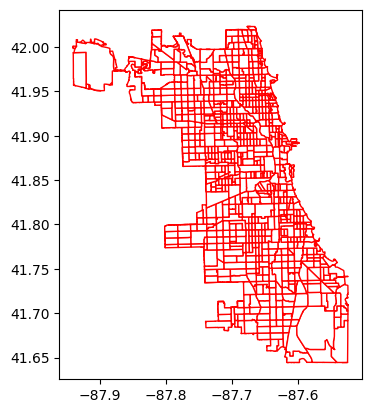

In [21]:
branchCopy = gpd.GeoDataFrame(
     branchCopy, geometry=gpd.points_from_xy(branchCopy.Longitude, branchCopy.Latitude), crs="EPSG:3435")

base = censusTracts.plot(color='white', edgecolor='red')


<Axes: title={'center': 'Raw Score of overlapping coverage'}>

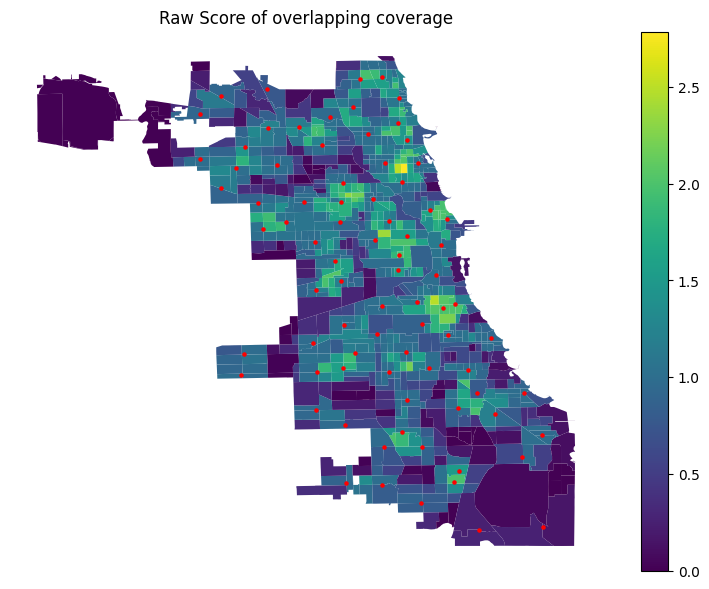

In [22]:
ax = censusTracts.plot(column = 'score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score of overlapping coverage")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Percent of access to at least one library'}>

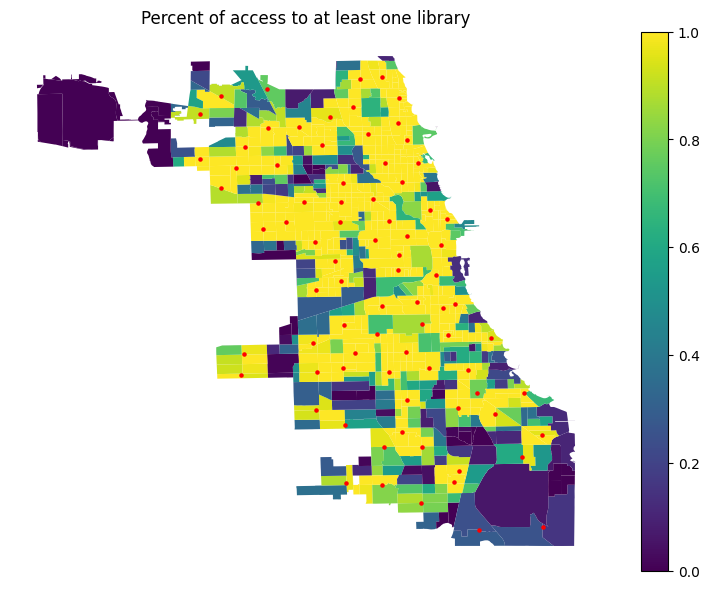

In [23]:
ax = censusTracts.plot(column = 'score norm', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of access to at least one library")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Percent of access to at least one library'}>

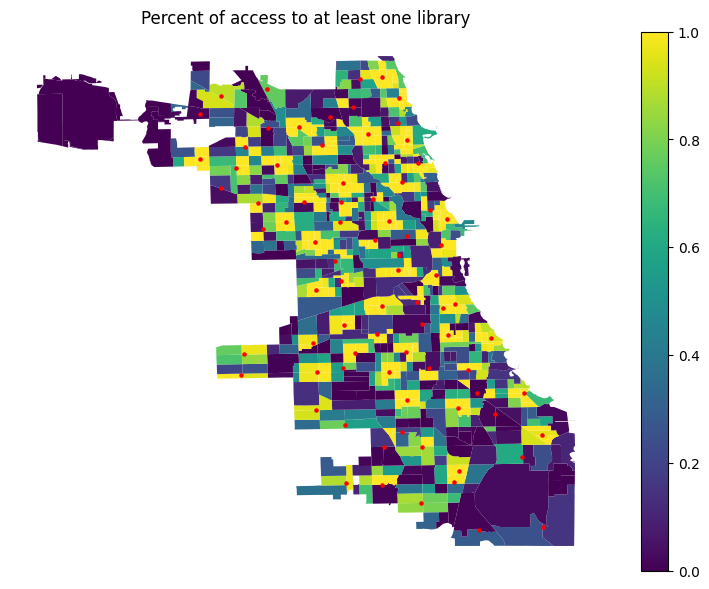

In [24]:
ax = censusTracts.plot(column = 'percent covered by at least one library', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of access to at least one library")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)
